## Imports

In [66]:
import os
import sys
import numpy as np
import time
import scipy
import matplotlib.pyplot as plt
import time
from scipy.stats import binned_statistic
from scipy.interpolate import interp1d

In [2]:
# import the frank2d directory
current_dir =  os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, os.pardir))
sys.path.append(parent_dir)

#frank2d
from frank2d import Frank2D
from constants import rad_to_arcsec
import constants as const
from plot import Plot
from fitting import IterativeSolverMethod
from preprocess_vis import Gridding
from geometry import Geometry

# frank1d
import frank
from frank.geometry import FixedGeometry, SourceGeometry, FitGeometryGaussian
from frank.radial_fitters import FrankFitter
from frank.utilities import UVDataBinner

### Functions

In [3]:
def get_radial_profile(frank_object):
    x = frank_object._FT._Xn*rad_to_arcsec
    y = frank_object._FT._Yn*rad_to_arcsec
    pixel_size = (x[1]-x[0])
    r = np.hypot(x, y)
    I = np.transpose(frank_object.sol_intensity)
    r = r.flatten()
    I = I.flatten()
    N = frank_object._Nx
    bin = (np.max(r) - np.min(r))/(N)
    I_binned, bin_edges, _ = binned_statistic(r, I, 'mean', N)
    r_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    return r_centers, I_binned

In [4]:
def get_vis_profile(frank_object):
    u = frank_object._FT._Un
    v = frank_object._FT._Vn
    pixel_size = (u[1]-u[0])
    q = np.hypot(u, v)
    Vis = frank_object.sol_visibility
    q = q.flatten()
    Vis = Vis.flatten()
    N = frank_object._Nx
    bin = (np.max(q) - np.min(q))/N
    weights_gridded = frank_object._gridded_data['weights']
    Vis_binned, bin_edges, _ = binned_statistic(q, Vis, 'mean', N)
    Vis_Weights_binned, bin_edges, _ = binned_statistic(q, Vis*weights_gridded, 'sum', N)
    Weights_binned, bin_edges, _ = binned_statistic(q, weights_gridded, 'sum', N)
    q_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    return q_centers, Vis_Weights_binned/Weights_binned

In [5]:
def deproject(u, v, inc, pa, inverse=False):  
    inc *= const.deg_to_rad
    pa *= const.deg_to_rad

    cos_t = np.cos(pa)
    sin_t = np.sin(pa)

    if inverse:
        sin_t *= -1
        u = u / np.cos(inc)

    up = u * cos_t - v * sin_t
    vp = u * sin_t + v * cos_t

    if inverse:
        return up, vp
    else:
    #   Deproject
        wp = up * np.sin(inc)
        up = up * np.cos(inc)

        return up, vp

In [6]:
def sweep_profile(r, I, project=False, phase_shift=False, geom=None, axis=0,
                  xmax=None, ymax=None, dr=None, deproject = False ):
    if project or deproject:
        inc, pa = geom['inc'], geom['pa']
        inc *= constants.deg_to_rad
        pa *= constants.deg_to_rad

        cos_i = np.cos(inc)
        cos_pa, sin_pa = np.cos(pa), np.sin(pa)

    if xmax is None:
        xmax = r.max()
    if ymax is None:
        ymax = r.max()

    if dr is None:
        dr = np.mean(np.diff(r))

    x = np.linspace(-xmax, xmax, int(xmax/dr))
    y = np.linspace(-ymax, ymax, int(ymax/dr))
    print(len(x))

    if phase_shift:
        xi, yi = np.meshgrid(x + geom['dra'], y - geom['ddec'])
    else:
        xi, yi = np.meshgrid(x, y)

    if project:
        xp  = xi * cos_pa + yi * sin_pa
        yp  = -xi * sin_pa + yi * cos_pa
        xp /= cos_i
        r1D = np.hypot(xp, yp)
    elif deproject:
        xp = xi * cos_i
        x_unrot = xp * cos_pa - yi * sin_pa
        y_unrot = xp * sin_pa + yi * cos_pa
        r1D = np.hypot(x_unrot, y_unrot)
    else:
        r1D = np.hypot(xi, yi)

    im_shape = r1D.shape + I.shape[1:]
    print(im_shape)

    interp = interp1d(r, I, bounds_error=False, fill_value=0., axis=axis)
    I2D = interp(r1D.ravel()).reshape(*im_shape)

    return I2D, xmax, ymax

In [7]:
def deproject_profile(r, I, phase_shift=False, geom=None, axis=0, xmax=None, ymax=None, dr=None):
    inc, pa = geom['inc'], geom['pa']
    inc *= constants.deg_to_rad
    pa *= constants.deg_to_rad

    cos_i = np.cos(inc)
    cos_pa, sin_pa = np.cos(pa), np.sin(pa)

    if xmax is None:
        xmax = r.max()
    if ymax is None:
        ymax = r.max()

    if dr is None:
        dr = np.mean(np.diff(r))

    x = np.linspace(-xmax, xmax, int(xmax/dr))
    y = np.linspace(-ymax, ymax, int(ymax/dr))

    if phase_shift:
        xi, yi = np.meshgrid(x + geom['dra'], y - geom['ddec'])
    else:
        xi, yi = np.meshgrid(x, y)

    xp = xi * cos_i
    x_unrot = xp * cos_pa - yi * sin_pa
    y_unrot = xp * sin_pa + yi * cos_pa
    r1D = np.hypot(x_unrot, y_unrot)

    return r1D, I

### Data

#### Elias24

In [8]:
# Huang 2018
inc = 29
pa = 45.7
dra = -110.8e-3
ddec = -386.8e-3
Rout = 2.1 #arcsecs


# UVtable
dir = "../../../data/"
data_file = dir +'Elias24_continuum_keepflagsFalse.txt'

 # load data||
u, v, Re, Imag, Weights = np.loadtxt(data_file, unpack = True)
Vis = Re + Imag*1j

geometry = {"inc": inc, "pa": pa, "dra": dra, "ddec":ddec}

#### AS209

In [9]:
# Huang 2018
inc = 34.97
pa = 85.76
dra = 1.9e-3
ddec = -2.5e-3
Rout = 2 #arcsecs

# UVtable
dir = "../../../data/"
data_file = dir +'AS209_continuum_prom_1chan_30s_keepflagsFalse.txt'

# load data||
u, v, Re, Imag, Weights = np.loadtxt(data_file, unpack = True)
Vis = Re + Imag*1j

## Frank2D

### Parameters

In [10]:
m, c, l = -0.33, -0.1, 1e5

In [11]:
N = 300

## Run

### Inspect gridded visibilities

In [12]:
geom = Geometry(inc, pa, dra, ddec, deproject = True)
frank2d = Frank2D(N, Rout, geom)

In [13]:
frank2d.preprocess_vis(u, v, Vis, Weights)

Deprojecting...


/Users/mariajmelladot/Desktop/Frank2D/6_Frank2D_Oficial/frank2d/preprocess_vis.py:46: RuntimeWarning: invalid value encountered in divide
  vis_gridded_matrix =  vis_weights_sum_bin/weights_sum_bin


  --> time = 0.03  min |  1.66 seconds
Setting gridded data...


In [14]:
u_gridded, v_gridded, vis_gridded, weights_gridded = frank2d._gridded_data['u'], frank2d._gridded_data['v'], frank2d._gridded_data['vis'], frank2d._gridded_data['weights']


In [15]:
FT = frank2d._FT
x_labels = np.fft.fftshift(FT._u/1e6)
y_labels = np.fft.fftshift(FT._v/1e6)

num_ticks = 5
x_ticks_to_show = np.linspace(0, len(x_labels) - 1, num_ticks).astype(int)
y_ticks_to_show = np.linspace(0, len(y_labels) - 1, num_ticks).astype(int)

def format_labels(x):
    return f"{int(x):d}" if abs(x) > 1e-8 else "0"

/var/folders/ng/vs__trg57hl3mtgq5kgkzj4h0000gn/T/ipykernel_32128/268744283.py:1: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(np.abs(np.fft.fftshift(vis_gridded.reshape(frank2d._FT._Nx, frank2d._FT._Ny)))), origin='lower')


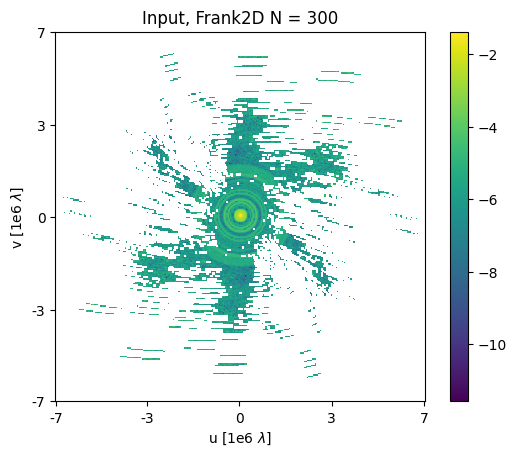

In [16]:
plt.imshow(np.log(np.abs(np.fft.fftshift(vis_gridded.reshape(frank2d._FT._Nx, frank2d._FT._Ny)))), origin='lower')
plt.xticks(ticks=x_ticks_to_show, labels=[format_labels(x) for x in np.array(x_labels)[x_ticks_to_show]])
plt.yticks(ticks=y_ticks_to_show, labels=[format_labels(y) for y in np.array(y_labels)[y_ticks_to_show]])
plt.xlabel(r'u [1e6 $\lambda$]')
plt.ylabel(r'v [1e6 $\lambda$]')
plt.title(F'Input, Frank2D N = {N}')
plt.colorbar()

/var/folders/ng/vs__trg57hl3mtgq5kgkzj4h0000gn/T/ipykernel_32128/2404421281.py:2: RuntimeWarning: divide by zero encountered in log
  plt.pcolormesh(np.fft.fftshift(v_gridded.reshape(N,N)), np.fft.fftshift(u_gridded.reshape(N,N)),  np.log(np.abs(np.fft.fftshift(vis_gridded.reshape(N,N)))))


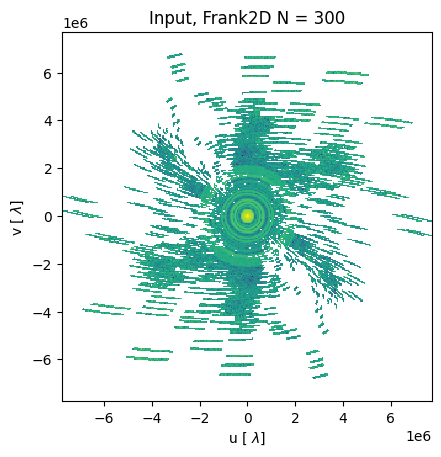

In [23]:
# Or directly with the gridded values of the uvs-space.
plt.pcolormesh(np.fft.fftshift(v_gridded.reshape(N,N)), np.fft.fftshift(u_gridded.reshape(N,N)),  np.log(np.abs(np.fft.fftshift(vis_gridded.reshape(N,N)))))
plt.xlabel(r'u [ $\lambda$]')
plt.ylabel(r'v [ $\lambda$]')
plt.title(F'Input, Frank2D N = {N}')
plt.gca().set_aspect('equal') 
plt.show()

### Running F2D

In [18]:
start_time = time.time()

#####
frank2d = Frank2D(N, Rout, Geometry(inc, pa, dra, ddec, deproject = True))
frank2d.set_kernel('Wendland', [m, c, l])
frank2d.fit(u, v, Vis, Weights, method = 'bicgstab', rtol = 1e-15, frank1d_guess = True, vis_component = 'all')

#####
print("--------------------------------------")
end_time = time.time()
execution_time = end_time - start_time
print(f'time = {execution_time/60 :.2f}  min | {execution_time: .2f} seconds')

Setting kernel: Wendland...
Gridding...
Deprojecting...


/Users/mariajmelladot/Desktop/Frank2D/6_Frank2D_Oficial/frank2d/preprocess_vis.py:46: RuntimeWarning: invalid value encountered in divide
  vis_gridded_matrix =  vis_weights_sum_bin/weights_sum_bin


  --> time = 0.03  min |  1.63 seconds
Setting gridded data...
Setting guess with Frank1D ...
Setting guess...
Setting fit with bicgstab ...
Fitting...
  *  Constructing linear operators...
Setting A...
Setting A_precond...
Setting b...
     --> time = 8.30  min |  497.74 seconds
  *  Solving linear system...
     * BICGSTAB
         * rtol: 1e-15
         * final tolerance: 3.6370190753312367e-08
         * maxiter:  900000
             .. iteration:  0
             .. iteration:  1
             .. iteration:  2
             .. iteration:  3
             .. iteration:  4
             .. iteration:  5
             .. iteration:  6
             .. iteration:  7
             .. iteration:  8
             .. iteration:  9
             .. iteration:  10
             .. iteration:  11
             .. iteration:  12
             .. iteration:  13
             .. iteration:  14
             .. iteration:  15
             .. iteration:  16
             .. iteration:  17
             .. iterati

In [24]:
frank2d.fft()

Inverting with 2fft ...
  --> time = 0.00  min |  0.00 seconds


In [25]:
vis_sol = frank2d.sol_visibility

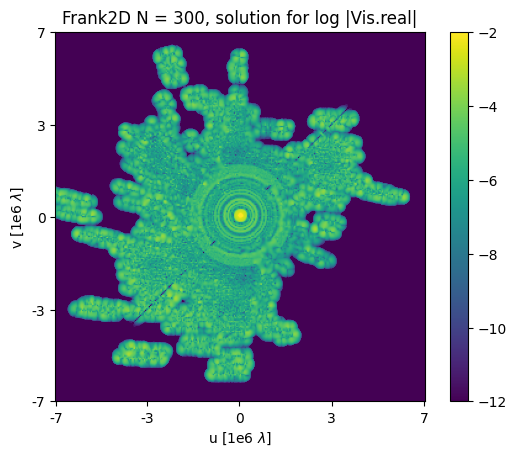

In [26]:
plt.imshow(np.log(np.abs(np.fft.fftshift(vis_sol.reshape(N, N)))), origin='lower', vmin=-12, vmax=-2)
plt.title(F'Frank2D N = {N}, solution for log |Vis.real|')
plt.xticks(ticks=x_ticks_to_show, labels=[format_labels(x) for x in np.array(x_labels)[x_ticks_to_show]])
plt.yticks(ticks=y_ticks_to_show, labels=[format_labels(y) for y in np.array(y_labels)[y_ticks_to_show]])
plt.xlabel(r'u [1e6 $\lambda$]')
plt.ylabel(r'v [1e6 $\lambda$]')
plt.colorbar()

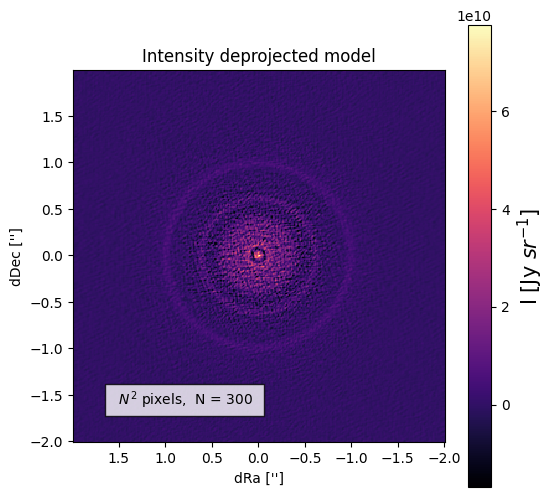

In [27]:
Plot(frank2d).get_image('Intensity deprojected model', size = 6)

In [28]:
r, I = get_radial_profile(frank2d)

In [30]:
start_time = time.time()

#####
frank2d_real = Frank2D(N, Rout, Geometry(inc, pa, dra, ddec, deproject = True))
frank2d_real.set_kernel('Wendland', [m, c, l])
frank2d_real.fit(u, v, Vis, Weights, method = 'bicgstab', rtol = 1e-15, frank1d_guess = False, vis_component = 'real')

#####
print("--------------------------------------")
end_time = time.time()
execution_time = end_time - start_time
print(f'time = {execution_time/60 :.2f}  min | {execution_time: .2f} seconds')

Setting kernel: Wendland...
Gridding...
Deprojecting...
  --> time = 0.03  min |  1.60 seconds
Setting gridded data...
Setting fit with bicgstab ...
Setting guess... Visibilities gridded
Fitting...
  *  Constructing linear operators...
Setting A...
Setting A_precond...
Setting b...
     --> time = 5.95  min |  356.92 seconds
  *  Solving linear system...
     * BICGSTAB
         * rtol: 1e-15
         * final tolerance: 3.6369110451157106e-08
         * maxiter:  900000
             .. iteration:  0
             .. iteration:  1
             .. iteration:  2
             .. iteration:  3
             .. iteration:  4
             .. iteration:  5
             .. iteration:  6
             .. iteration:  7
             .. iteration:  8
             .. iteration:  9
             .. iteration:  10
             .. iteration:  11
             .. iteration:  12
             .. iteration:  13
             .. iteration:  14
             .. iteration:  15
             .. iteration:  16
        

In [31]:
vis_sol_real = frank2d_real.sol_visibility
print(vis_sol_real.imag)

[0. 0. 0. ... 0. 0. 0.]


/var/folders/ng/vs__trg57hl3mtgq5kgkzj4h0000gn/T/ipykernel_32128/2792164125.py:1: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(np.abs(np.fft.fftshift(vis_sol_real.reshape(N, N)))), origin='lower', vmin=-12, vmax=-2)


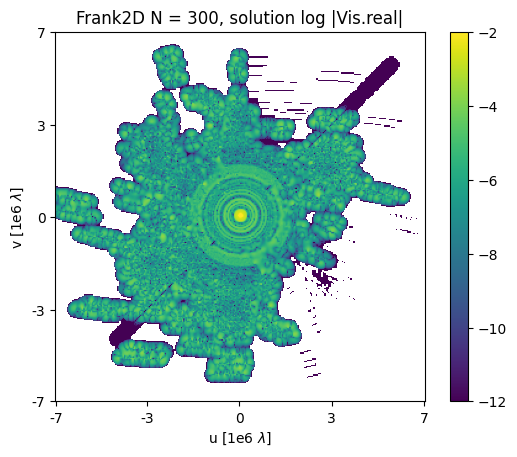

In [32]:
plt.imshow(np.log(np.abs(np.fft.fftshift(vis_sol_real.reshape(N, N)))), origin='lower', vmin=-12, vmax=-2)
plt.title(F'Frank2D N = {N}, solution log |Vis.real|')
plt.xticks(ticks=x_ticks_to_show, labels=[format_labels(x) for x in np.array(x_labels)[x_ticks_to_show]])
plt.yticks(ticks=y_ticks_to_show, labels=[format_labels(y) for y in np.array(y_labels)[y_ticks_to_show]])
plt.xlabel(r'u [1e6 $\lambda$]')
plt.ylabel(r'v [1e6 $\lambda$]')
plt.colorbar()

In [33]:
start_time = time.time()

#####
frank2d_imag = Frank2D(N, Rout, Geometry(inc, pa, dra, ddec, deproject = True))
frank2d_imag.set_kernel('Wendland', [m, c, l])
frank2d_imag.fit(u, v, Vis, Weights, method = 'bicgstab', rtol = 1e-15, frank1d_guess = False, vis_component = 'imag')

#####
print("--------------------------------------")
end_time = time.time()
execution_time = end_time - start_time
print(f'time = {execution_time/60 :.2f}  min | {execution_time: .2f} seconds')

Setting kernel: Wendland...
Gridding...
Deprojecting...


/Users/mariajmelladot/Desktop/Frank2D/6_Frank2D_Oficial/frank2d/preprocess_vis.py:46: RuntimeWarning: invalid value encountered in divide
  vis_gridded_matrix =  vis_weights_sum_bin/weights_sum_bin


  --> time = 0.02  min |  1.26 seconds
Setting gridded data...
Setting fit with bicgstab ...
Setting guess... Visibilities gridded
Fitting...
  *  Constructing linear operators...
Setting A...
Setting A_precond...
Setting b...
     --> time = 4.55  min |  272.74 seconds
  *  Solving linear system...
     * BICGSTAB
         * rtol: 1e-15
         * final tolerance: 2.8032200032144154e-10
         * maxiter:  900000
             .. iteration:  0
             .. iteration:  1
             .. iteration:  2
             .. iteration:  3
             .. iteration:  4
             .. iteration:  5
             .. iteration:  6
             .. iteration:  7
             .. iteration:  8
             .. iteration:  9
             .. iteration:  10
             .. iteration:  11
             .. iteration:  12
             .. iteration:  13
             .. iteration:  14
             .. iteration:  15
             .. iteration:  16
             .. iteration:  17
             .. iteration:  18
  

In [34]:
vis_sol_imag = frank2d_imag.sol_visibility

/var/folders/ng/vs__trg57hl3mtgq5kgkzj4h0000gn/T/ipykernel_32128/4151732461.py:1: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(np.abs(np.fft.fftshift(vis_sol_imag.reshape(N, N)))), origin='lower', vmin=-12, vmax=-2)


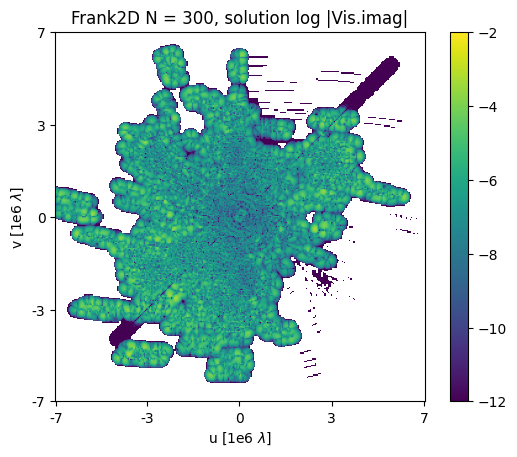

In [35]:
plt.imshow(np.log(np.abs(np.fft.fftshift(vis_sol_imag.reshape(N, N)))), origin='lower', vmin=-12, vmax=-2)
plt.xticks(ticks=x_ticks_to_show, labels=[format_labels(x) for x in np.array(x_labels)[x_ticks_to_show]])
plt.yticks(ticks=y_ticks_to_show, labels=[format_labels(y) for y in np.array(y_labels)[y_ticks_to_show]])
plt.xlabel(r'u [1e6 $\lambda$]')
plt.ylabel(r'v [1e6 $\lambda$]')
plt.title(F'Frank2D N = {N}, solution log |Vis.imag|')
plt.colorbar()

In [46]:
frank2d_joined = Frank2D(N, Rout, Geometry(inc, pa, dra, ddec, deproject = True))
frank2d_joined.sol_visibility = frank2d_real.sol_visibility + frank2d_imag.sol_visibility

**Let's see if there the result is consistent**

In [47]:
np.where(frank2d_imag.sol_visibility.real  != 0)

(array([], dtype=int64),)

In [48]:
np.where(frank2d_real.sol_visibility.imag  != 0)

(array([], dtype=int64),)

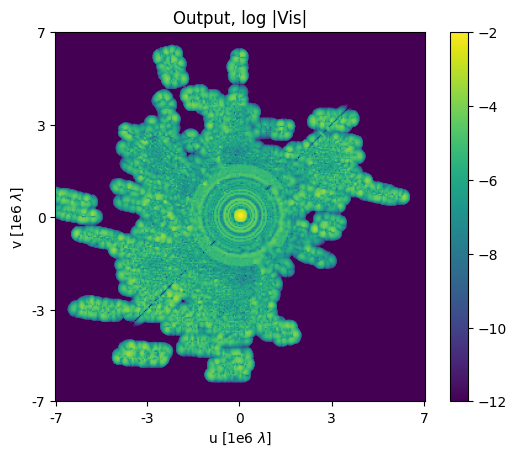

In [49]:
plt.imshow(np.log(np.abs(np.fft.fftshift(frank2d.sol_visibility.reshape(N, N)))), origin='lower', vmin=-12, vmax=-2)
plt.xticks(ticks=x_ticks_to_show, labels=[format_labels(x) for x in np.array(x_labels)[x_ticks_to_show]])
plt.yticks(ticks=y_ticks_to_show, labels=[format_labels(y) for y in np.array(y_labels)[y_ticks_to_show]])
plt.xlabel(r'u [1e6 $\lambda$]')
plt.ylabel(r'v [1e6 $\lambda$]')
plt.title(F'Output, log |Vis|')
plt.colorbar()

In [50]:
frank2d_joined.fft()

Inverting with 2fft ...
  --> time = 0.00  min |  0.00 seconds


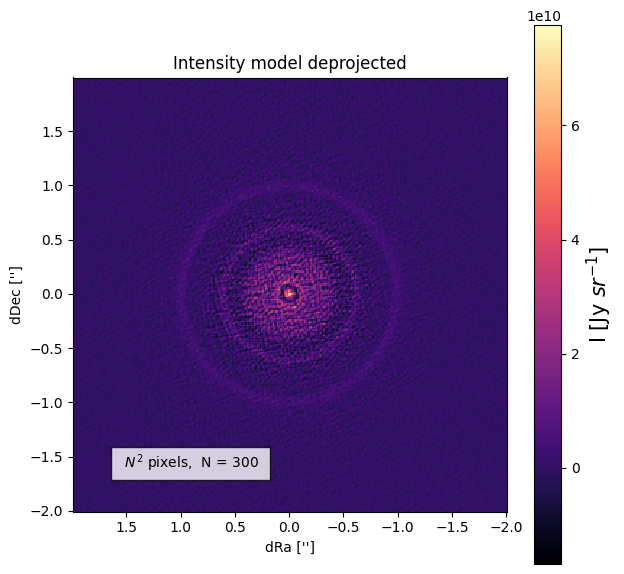

In [51]:
Plot(frank2d_joined).get_image('Intensity model deprojected')

In [52]:
r_joined, I_joined = get_radial_profile(frank2d_joined)

In [53]:
frank2d_dif = Frank2D(N, Rout, Geometry(inc, pa, dra, ddec, deproject = True))
frank2d_dif.sol_intensity = frank2d_joined.sol_intensity - frank2d.sol_intensity

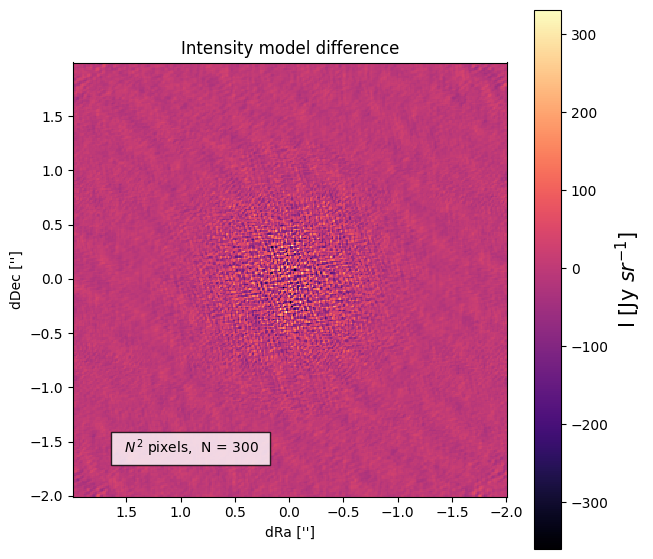

In [54]:
Plot(frank2d_dif).get_image('Intensity model difference')

### Frank1D

In [56]:
# Frank 1D Parameters
n_pts = 300
alpha = 1.3
w_smooth = 1e-3

geom = SourceGeometry(inc= inc, PA= pa, dRA= dra, dDec= ddec)
FF = FrankFitter(Rout, n_pts, geom, alpha = alpha, weights_smooth = w_smooth)
sol = FF.fit(u, v, Vis, Weights)

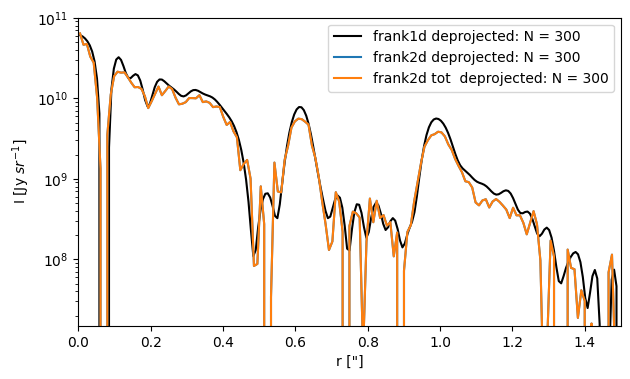

In [57]:
plt.figure(figsize=(7,4))
plt.plot(sol.r, sol.mean, 'black',label =f'frank1d deprojected: N = {n_pts}')
plt.plot(r, I, label = f'frank2d deprojected: N = {N}')
plt.plot(r_joined, I_joined, label = f'frank2d tot  deprojected: N = {N}')
plt.xlabel('r ["]')
plt.xlim(0,1.5)      
plt.ylim(1.5e7, 1e11)
plt.ylabel(r'I [Jy $sr^{-1}$]')
plt.legend()
plt.yscale("log")
plt.show()

/var/folders/ng/vs__trg57hl3mtgq5kgkzj4h0000gn/T/ipykernel_32128/246954407.py:5: RuntimeWarning: divide by zero encountered in log10
  grid = np.logspace(np.log10(min(baselines.min(), baselines[0])),
/Users/mariajmelladot/Desktop/Frank2D/0_Frank1D/frank/frank/utilities.py:224: RuntimeWarning: invalid value encountered in divide
  bin_uv[idx] /= w
/Users/mariajmelladot/Desktop/Frank2D/0_Frank1D/frank/frank/utilities.py:225: RuntimeWarning: invalid value encountered in divide
  bin_vis[idx] /= w
/Users/mariajmelladot/Desktop/Frank2D/0_Frank1D/frank/frank/utilities.py:250: RuntimeWarning: invalid value encountered in divide
  err[idx2] /= bin_wgt[idx2]**2 * (1 - 1 / bin_n[idx2])
/Users/mariajmelladot/Desktop/Frank2D/0_Frank1D/frank/frank/utilities.py:259: RuntimeWarning: divide by zero encountered in divide
  bin_vis_err[idx1].real = 1 / np.sqrt(bin_wgt[idx1])
/var/folders/ng/vs__trg57hl3mtgq5kgkzj4h0000gn/T/ipykernel_32128/1432917310.py:17: RuntimeWarning: invalid value encountered in di

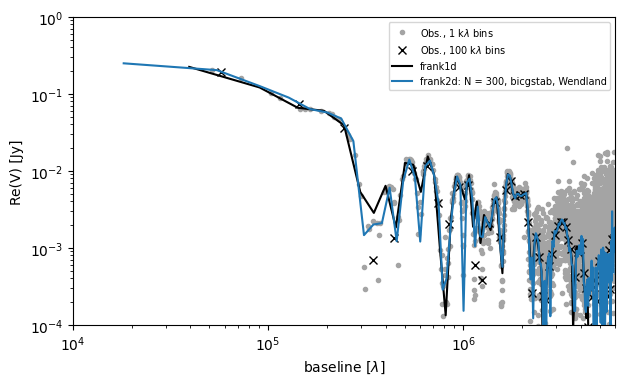

In [65]:
cs, ms = ['#a4a4a4', 'k'], ['.', 'x']
bin_widths=[1e3, 1e5]
u_gridded, v_gridded, vis_gridded, weights_gridded = frank2d._gridded_data['u'], frank2d._gridded_data['v'], frank2d._gridded_data['vis'], frank2d._gridded_data['weights']
baselines = np.hypot(u_gridded, v_gridded)         
grid = np.logspace(np.log10(min(baselines.min(), baselines[0])),
                           np.log10(max(baselines.max(), baselines[-1])),
                           10**4)

plt.figure(figsize=(7,4))

for i in range(len(bin_widths)):
            binned_vis = UVDataBinner(baselines, frank2d.sol_visibility, weights_gridded, bin_widths[i])
            plt.plot(binned_vis.uv, np.abs(binned_vis.V), c=cs[i],
                         marker=ms[i], ls='None', 
                         label=r'Obs., {:.0f} k$\lambda$ bins'.format(bin_widths[i]/1e3))


#frank1d
vis_fit_1d = sol.predict_deprojected(sol.q)
baselines_fit_1d = sol.q
plt.plot(baselines_fit_1d, np.abs(vis_fit_1d), color = "black", label = r'frank1d')

#frank2d
q, Vis_1= get_vis_profile(frank2d)
plt.plot(q, np.abs(Vis_1.real), label = f'frank2d: N = {N}, bicgstab, Wendland')

plt.xlabel(r'baseline [$\lambda$]')
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-4, 1)
plt.xlim(1e4, 6e6)
plt.ylabel('Re(V) [Jy]', size = 10)
plt.legend(fontsize =7)
plt.show()

### Comparing with CLEAN

In [311]:
# Obtain the radial profiles convolved to a circular beam.
from gofish import imagecube

infile_1mm = dir + 'AS209_1mm_13s_conv_circ.fits'
#2D->1D
cube_1mm = imagecube(infile_1mm)
x_1mm,y_1mm,dy_1mm = cube_1mm.radial_profile(inc=inc, PA=pa, x0=dra, y0=ddec)

	 Reverting to standard azimuthal averaging; will ignore `unit` argument.


In [312]:
from frank.utilities import convolve_profile

clean_beam_1mm = {'bmaj':0.0373, 'bmin':0.0373, 'beam_pa':31.040}
area_1mm = clean_beam_1mm['bmaj']*clean_beam_1mm['bmin']*np.pi/4./np.log(2.)*(1/rad_to_arcsec)**2

convolved_1mm_frank2d = convolve_profile(r, I, inc, pa, clean_beam_1mm)*area_1mm
convolved_1mm_frank1d = convolve_profile(sol.r, sol.mean, inc, pa, clean_beam_1mm)*area_1mm

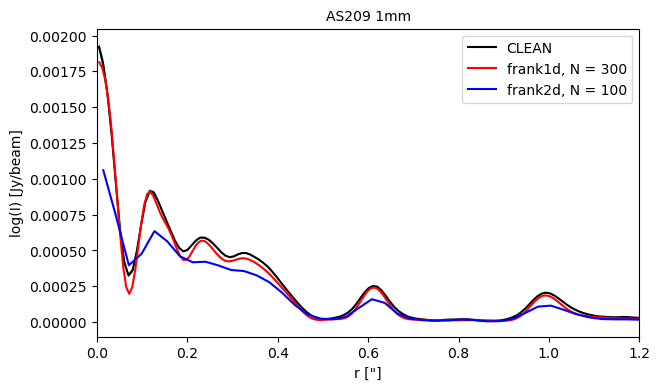

In [313]:
plt.figure(figsize=(7, 4))
plt.plot(x_1mm, y_1mm, "black", label = "CLEAN")
plt.fill_between(x_1mm, y_1mm-dy_1mm, y_1mm+dy_1mm,alpha=0.7)
plt.plot(sol.r, convolved_1mm_frank1d, "red", label=r'frank1d' + ', N = ' +str(n_pts))
plt.plot(r,convolved_1mm_frank2d, "blue", label=r'frank2d' + ', N = ' +str(N))
plt.title(r'AS209 1mm', size=10)
plt.ylabel("log(I) [Jy/beam]", size=10)
plt.xlabel('r ["]', size=10)
plt.legend(fontsize=10)
#plt.yscale('log')
#plt.ylim(0.1e-5, 0.5e-2)
plt.xlim(0,1.2)
plt.show()